In [19]:
from astroquery.mast import Observations
from ccdproc import ImageFileCollection
from astropy.table import Table
from astropy.io import fits
from astropy.io import ascii
from astropy.visualization import ZScaleInterval
from IPython.display import Image
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
from drizzlepac import tweakreg
from drizzlepac import astrodrizzle

In [20]:
science_list = Observations.query_criteria(proposal_id='16231', filters='F150LP',obs_id='jec401*')
Observations.download_products(science_list['obsid'], mrp_only=False, download_dir='./science',\
                               productSubGroupDescription=['FLT'])

science_files = glob.glob(os.path.join(os.curdir, 'science', 'mastDownload', 'HST', '*', '*fits'))
for im in science_files:
    root = im.split('/')[-1]
    os.rename(im, './' + root)
shutil.rmtree('science/')

In [21]:
science_list = Observations.query_criteria(proposal_id='16231', filters='F150LP',obs_id='jec403*')
Observations.download_products(science_list['obsid'], mrp_only=False, download_dir='./science',\
                               productSubGroupDescription=['FLT'])

science_files = glob.glob(os.path.join(os.curdir, 'science', 'mastDownload', 'HST', '*', '*fits'))
for im in science_files:
    root = im.split('/')[-1]
    os.rename(im, './' + root)
shutil.rmtree('science/')

In [22]:
no = 'hst_16231_01_acs_sbc_f150lp_jec401no_flt.fits'
nr = 'hst_16231_01_acs_sbc_f150lp_jec401nr_flt.fits'
nv = 'hst_16231_01_acs_sbc_f150lp_jec401nv_flt.fits'
nx = 'hst_16231_01_acs_sbc_f150lp_jec401nx_flt.fits'
lst_1 = [no, nr, nv, nx]

In [23]:
ib = 'hst_16231_03_acs_sbc_f150lp_jec403ib_flt.fits'
ic = 'hst_16231_03_acs_sbc_f150lp_jec403ic_flt.fits'
id3 = 'hst_16231_03_acs_sbc_f150lp_jec403id_flt.fits'
ie = 'hst_16231_03_acs_sbc_f150lp_jec403ie_flt.fits'
lst_3 = [ib, ic, id3, ie]

In [24]:
gv = 'hst_16231_04_acs_sbc_f150lp_jec404gv_flt.fits'
gw = 'hst_16231_04_acs_sbc_f150lp_jec404gw_flt.fits'
gx = 'hst_16231_04_acs_sbc_f150lp_jec404gx_flt.fits'
gy = 'hst_16231_04_acs_sbc_f150lp_jec404gy_flt.fits'
lst_4 = [gv, gw, gx, gy]

In [52]:
i7 = 'hst_16231_09_acs_sbc_f150lp_jec409i7_flt.fits'
i8 = 'hst_16231_09_acs_sbc_f150lp_jec409i8_flt.fits'
i9 = 'hst_16231_09_acs_sbc_f150lp_jec409i9_flt.fits'
ia = 'hst_16231_09_acs_sbc_f150lp_jec409ia_flt.fits'
lst_9 = [i7, i8, i9, ia]

In [25]:
def coo_pixtosky(r):
    return np.matmul(A, r-r0) + B

In [26]:
def coo_skytopix(r_sky):
    return np.matmul(A_inv, r_sky - B) + r0

In [27]:
def find_center(inputfilename):
    file = fits.open(inputfilename)
    #WCS info from header
    CRVAL1 = file[1].header['CRVAL1']
    CRVAL2 = file[1].header['CRVAL2']
    CRPIX1 = file[1].header['CRPIX1']
    CRPIX2 = file[1].header['CRPIX2']
    CD1_1 = file[1].header['CD1_1']
    CD1_2 = file[1].header['CD1_2']
    CD2_1 = file[1].header['CD2_1']
    CD2_2 = file[1].header['CD2_2']
    
    A = np.array([[CD1_1, CD1_2], [CD2_1, CD2_2]])
    A_inv = np.linalg.inv(A)
    B = np.array([[CRVAL1],[CRVAL2]])
    r0 = np.array([[CRPIX1],[CRPIX2]])
    
    def coo_pixtosky(r):
        return np.matmul(A, r-r0) + B
    
    def coo_skytopix(r_sky):
        return np.matmul(A_inv, r_sky - B) + r0
    
    #Target location info
    RA_TARG = file[0].header['RA_TARG'] 
    DEC_TARG = file[0].header['DEC_TARG']
    r_sky_TARG = np.array([[RA_TARG], [DEC_TARG]])
    X_TARG, Y_TARG = int(coo_skytopix(r_sky_TARG)[0]), int(coo_skytopix(r_sky_TARG)[1])
    
    data = file[1].data
    
    s = 100
    max_i = 0
    max_j = 0
    maxval = 0
    for i in range(Y_TARG-s, Y_TARG+s+1):
        for j in range(X_TARG-s, X_TARG+s+1):
            if data[i][j] > maxval:
                maxval = data[i][j]
                max_i = i
                max_j = j 
    r = 50
    total_flux = 0
    i_integral = 0
    j_integral = 0
    for i in range(max_i-r, max_i+r+1):
        for j in range(max_j-r, max_j+r+1):
            total_flux += data[i][j]
            i_integral += i*data[i][j]
            j_integral += j*data[i][j]
    
    i_center = i_integral/total_flux
    j_center = j_integral/total_flux
    
    X_center = j_center +1
    Y_center = i_center +1
    r_center = np.array([[X_center], [Y_center]])
    
    #print('X_center =', X_center)
    #print('Y_center =', Y_center)
    sky_coo_center = coo_pixtosky(r_center)
    #RA_center, DEC_center = sky_coo_center[0][0], sky_coo_center[1][0]
    return r_center, sky_coo_center


In [60]:
for file in lst_1+lst_3+lst_4 + lst_9:
    print(fits.open(file)[0].header['ROOTNAME'][-4:])
    print(find_center(file)[1])

1noq
[[3.19600544e+02]
 [2.91488262e-01]]
1nrq
[[3.19600547e+02]
 [2.91493212e-01]]
1nvq
[[3.19600555e+02]
 [2.91503937e-01]]
1nxq
[[3.19600548e+02]
 [2.91513909e-01]]
3ibq
[[3.19600559e+02]
 [2.91539057e-01]]
3icq
[[3.19600552e+02]
 [2.91537808e-01]]
3idq
[[3.19600545e+02]
 [2.91540508e-01]]
3ieq
[[3.19600542e+02]
 [2.91541044e-01]]
4gvq
[[3.19600049e+02]
 [2.91476192e-01]]
4gwq
[[3.19600051e+02]
 [2.91473430e-01]]
4gxq
[[3.19600051e+02]
 [2.91474535e-01]]
4gyq
[[3.19600039e+02]
 [2.91473453e-01]]
9i7q
[[3.19600528e+02]
 [2.91414540e-01]]
9i8q
[[3.19600526e+02]
 [2.91414104e-01]]
9i9q
[[3.19600525e+02]
 [2.91418848e-01]]
9iaq
[[3.19600527e+02]
 [2.91411420e-01]]


In [8]:
def avg_center(lst):
    a = np.array([[0.0],[0.0]])
    for item in lst:
        a += find_center(item)[1]
    return a/len(lst)

In [53]:
avg_center0 = avg_center(lst_1 + lst_3 + lst_4 + lst_9)
avg_center0

array([[3.19600418e+02],
       [2.91482141e-01]])

In [32]:
def new_CRVALs(inputfilename, ref_center):
    file = fits.open(inputfilename)
    #WCS info from header
    CRVAL1 = file[1].header['CRVAL1']
    CRVAL2 = file[1].header['CRVAL2']
    CRPIX1 = file[1].header['CRPIX1']
    CRPIX2 = file[1].header['CRPIX2']
    CD1_1 = file[1].header['CD1_1']
    CD1_2 = file[1].header['CD1_2']
    CD2_1 = file[1].header['CD2_1']
    CD2_2 = file[1].header['CD2_2']
    
    A = np.array([[CD1_1, CD1_2], [CD2_1, CD2_2]])
    r0 = np.array([[CRPIX1],[CRPIX2]])
    
    coo_center = find_center(inputfilename)
    r_center = coo_center[0]
    sky_coo_center = coo_center[1]
    
    new_CRVALs = ref_center - np.matmul(A, r_center - r0)
    return new_CRVALs

In [54]:
for file in lst_1+lst_3+lst_4+ lst_9:
    
    print(fits.open(file)[0].header['ROOTNAME'][-4:])
    print(new_CRVALs(file, avg_center0)[0])

1noq
[319.60095822]
1nrq
[319.60100983]
1nvq
[319.60084321]
1nxq
[319.6007945]
3ibq
[319.60056374]
3icq
[319.60065144]
3idq
[319.6004961]
3ieq
[319.60041808]
4gvq
[319.6004179]
4gwq
[319.60038718]
4gxq
[319.60054163]
4gyq
[319.60058179]
9i7q
[319.60063288]
9i8q
[319.60059557]
9i9q
[319.60046201]
9iaq
[319.60049864]


In [56]:
for item in lst_1+lst_3 + lst_4 + lst_9:
    file = fits.open(item, mode = 'update')
    newname = file[0].header['ROOTNAME'][-4:]
    new_crvals = new_CRVALs(item, avg_center0)
    for i in [1,2,3]:
        file[i].header['CRVAL1'] = new_crvals[0][0]
        file[i].header['CRVAL2'] = new_crvals[1][0]
    
    file.writeto(newname + '.fits', overwrite = True)

In [58]:
lst_up = []
for item in lst_1 + lst_3+ lst_4 + lst_9:
    lst_up.append(item[33:36]+ 'q.fits')
lst_up

['1noq.fits',
 '1nrq.fits',
 '1nvq.fits',
 '1nxq.fits',
 '3ibq.fits',
 '3icq.fits',
 '3idq.fits',
 '3ieq.fits',
 '4gvq.fits',
 '4gwq.fits',
 '4gxq.fits',
 '4gyq.fits',
 '9i7q.fits',
 '9i8q.fits',
 '9i9q.fits',
 '9iaq.fits']

In [ ]:
file = fits.open(nr)

In [59]:
astrodrizzle.AstroDrizzle(lst_up, 
                              output = 'total_visit1349_test9', 
                              clean = True,
                              build = True,
                              context = True,
                              runfile = 'total_visit1349_drz.log',
                              num_cores = 1,
                              in_memory = False,
                              resetbits = 4096,
                              median = False,
                              static = False,
                              skysub = False,
                              driz_separate = False,
                              blot = False,
                              driz_cr = False,
                              final_bits = 0,
                              final_outnx=1947,
                              final_outny=1960, 
                              final_rot = 0.0,
                              final_scale = 0.025,
                              final_wcs = True)

INFO:drizzlepac.util:Setting up logfile :  total_visit1349_drz.log


Setting up logfile :  total_visit1349_drz.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle log file: total_visit1349_drz.log


AstroDrizzle log file: total_visit1349_drz.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 3.4.2 started at: 09:52:51.640 (13/06/2022)


AstroDrizzle Version 3.4.2 started at: 09:52:51.640 (13/06/2022)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information
INFO:drizzlepac.astrodrizzle:--------------------
INFO:drizzlepac.astrodrizzle:Python Version [Clang 12.0.0 ]
INFO:drizzlepac.astrodrizzle:3.9.12 (main, Jun  1 2022, 06:36:29) 
INFO:drizzlepac.astrodrizzle:numpy Version -> 1.22.4 
INFO:drizzlepac.astrodrizzle:astropy Version -> 5.1 
INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.7.2 
INFO:drizzlepac.util:==== Processing Step  Initialization  started at  09:52:51.648 (13/06/2022)


==== Processing Step  Initialization  started at  09:52:51.648 (13/06/2022)


INFO:drizzlepac.util:


INFO:drizzlepac.processInput:Preserving original of:  4gvq.fits as  OrIg_files/4gvq.fits


Preserving original of:  4gvq.fits as  OrIg_files/4gvq.fits


INFO:drizzlepac.processInput:Preserving original of:  4gwq.fits as  OrIg_files/4gwq.fits


Preserving original of:  4gwq.fits as  OrIg_files/4gwq.fits


INFO:drizzlepac.processInput:Preserving original of:  4gxq.fits as  OrIg_files/4gxq.fits


Preserving original of:  4gxq.fits as  OrIg_files/4gxq.fits


INFO:drizzlepac.processInput:Preserving original of:  4gyq.fits as  OrIg_files/4gyq.fits


Preserving original of:  4gyq.fits as  OrIg_files/4gyq.fits


INFO:drizzlepac.processInput:Preserving original of:  9i7q.fits as  OrIg_files/9i7q.fits


Preserving original of:  9i7q.fits as  OrIg_files/9i7q.fits


INFO:drizzlepac.processInput:Preserving original of:  9i8q.fits as  OrIg_files/9i8q.fits


Preserving original of:  9i8q.fits as  OrIg_files/9i8q.fits


INFO:drizzlepac.processInput:Preserving original of:  9i9q.fits as  OrIg_files/9i9q.fits


Preserving original of:  9i9q.fits as  OrIg_files/9i9q.fits


INFO:drizzlepac.processInput:Preserving original of:  9iaq.fits as  OrIg_files/9iaq.fits


Preserving original of:  9iaq.fits as  OrIg_files/9iaq.fits


INFO:drizzlepac.processInput:Executing serially
INFO:drizzlepac.processInput:Setting up output name: total_visit1349_test9_drz.fits
INFO:drizzlepac.processInput:##############################################################################


##############################################################################


INFO:drizzlepac.processInput:#                                                                            #


#                                                                            #


INFO:drizzlepac.processInput:# “minmed” is highly recommended for three images,                           #


# “minmed” is highly recommended for three images,                           #


INFO:drizzlepac.processInput:#  and is good for four to six images,                                       #


#  and is good for four to six images,                                       #


INFO:drizzlepac.processInput:#  but should be avoided for ten or more images.                             #


#  but should be avoided for ten or more images.                             #


INFO:drizzlepac.processInput:#                                                                            #


#                                                                            #


INFO:drizzlepac.processInput:##############################################################################


##############################################################################


INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0
INFO:drizzlepac.acsData:WARNING: No cte correction will be made for this SBC data.


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0
INFO:drizzlepac.acsData:WARNING: No cte correction will be made for this SBC data.


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0
INFO:drizzlepac.acsData:WARNING: No cte correction will be made for this SBC data.


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0
INFO:drizzlepac.acsData:WARNING: No cte correction will be made for this SBC data.


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0
INFO:drizzlepac.acsData:WARNING: No cte correction will be made for this SBC data.


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0
INFO:drizzlepac.acsData:WARNING: No cte correction will be made for this SBC data.


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0
INFO:drizzlepac.acsData:WARNING: No cte correction will be made for this SBC data.


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0
INFO:drizzlepac.acsData:WARNING: No cte correction will be made for this SBC data.


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0
INFO:drizzlepac.acsData:WARNING: No cte correction will be made for this SBC data.


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0
INFO:drizzlepac.acsData:WARNING: No cte correction will be made for this SBC data.


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0
INFO:drizzlepac.acsData:WARNING: No cte correction will be made for this SBC data.


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0
INFO:drizzlepac.acsData:WARNING: No cte correction will be made for this SBC data.


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0
INFO:drizzlepac.acsData:WARNING: No cte correction will be made for this SBC data.


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0
INFO:drizzlepac.acsData:WARNING: No cte correction will be made for this SBC data.


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0
INFO:drizzlepac.acsData:WARNING: No cte correction will be made for this SBC data.


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0
INFO:drizzlepac.acsData:WARNING: No cte correction will be made for this SBC data.


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in 1noq.fits[DQ,1]
INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in 1nrq.fits[DQ,1]
INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in 1nvq.fits[DQ,1]
INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in 1nxq.fits[DQ,1]
INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in 3ibq.fits[DQ,1]
INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in 3icq.fits[DQ,1]
INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in 3idq.fits[DQ,1]
INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in 3ieq.fits[DQ,1]
INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in 4gvq.fits[DQ,1]
INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in 4gwq.fits[DQ,1]
INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in 4gxq.fits[DQ,1]
INFO:drizzlepac.resetbits:Reset bit values of 4096 to 

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 319.60072654272636  0.2915652990259774  


CRVAL : 319.60072654272636  0.2915652990259774  


INFO:astropy.wcs.wcs:CRPIX : 974.0  980.5  


CRPIX : 974.0  980.5  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : -6.944444444444445e-06  -4.235164736271502e-22  


CD1_1 CD1_2  : -6.944444444444445e-06  -4.235164736271502e-22  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -4.235164736271502e-22  6.944444444444445e-06  


CD2_1 CD2_2  : -4.235164736271502e-22  6.944444444444445e-06  


INFO:astropy.wcs.wcs:NAXIS : 1947  1960


NAXIS : 1947  1960


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 51 Mb.


*  Estimated memory usage:  up to 51 Mb.


INFO:drizzlepac.processInput:*  Output image size:       1947 X 1960 pixels. 


*  Output image size:       1947 X 1960 pixels. 


INFO:drizzlepac.processInput:*  Output image file:       ~ 43 Mb. 


*  Output image file:       ~ 43 Mb. 


INFO:drizzlepac.processInput:*  Cores available:         1


*  Cores available:         1


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.util:==== Processing Step Initialization finished at 09:52:53.729 (13/06/2022)


==== Processing Step Initialization finished at 09:52:53.729 (13/06/2022)


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.astrodrizzle:	build :	True
INFO:drizzlepac.astrodrizzle:	coeffs :	True
INFO:drizzlepac.astrodrizzle:	context :	True
INFO:drizzlepac.astrodrizzle:	crbit :	4096
INFO:drizzlepac.astrodrizzle:	group :	
INFO:drizzlepac.astrodrizzle:	in_memory :	False
INFO:drizzlepac.astrodrizzle:	input :	['1noq.fits', '1nrq.fits', '1nvq.fits', '1nxq.fits', '3ibq.fits', '3icq.fits', '3idq.fits', '3ieq.fits', '4gvq.fits', '4gwq.fits', '4gxq.fits', '4gyq.fits', '9i7q.fits', '9i8q.fits', '9i9q.fits', '9iaq.fits']
INFO:drizzlepac.astrodrizzle:	mdriztab :	False
INFO:drizzlepac.astrodrizzle:	num_cores :	1
INFO:drizzlepac.astrodrizzle:	output :	total_visit1349_test9
INFO:drizzlepac.astrodrizzle:	proc_unit :	native
INFO:drizzlepac.astrodrizzle:	resetbits :	4096
INFO:drizzlepac.astrodrizzle:	rules_file :	
INFO:drizzlepac.astrodrizzle:	runfile :	total_visit1349_drz.log
INFO:drizzlepac.astrodrizzle:	stepsize :	10
INFO:dri

==== Processing Step  Static Mask  started at  09:52:53.737 (13/06/2022)


INFO:drizzlepac.util:


INFO:drizzlepac.staticMask:Static Mask step not performed.
INFO:drizzlepac.util:==== Processing Step Static Mask finished at 09:52:53.739 (13/06/2022)


==== Processing Step Static Mask finished at 09:52:53.739 (13/06/2022)


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  09:52:53.740 (13/06/2022)


==== Processing Step  Subtract Sky  started at  09:52:53.740 (13/06/2022)


INFO:drizzlepac.util:


INFO:drizzlepac.sky:Sky Subtraction step not performed.
INFO:drizzlepac.util:==== Processing Step Subtract Sky finished at 09:52:54.108 (13/06/2022)


==== Processing Step Subtract Sky finished at 09:52:54.108 (13/06/2022)


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  09:52:54.10 (13/06/2022)


==== Processing Step  Separate Drizzle  started at  09:52:54.10 (13/06/2022)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Single drizzle step not performed.
INFO:drizzlepac.util:==== Processing Step Separate Drizzle finished at 09:52:54.110 (13/06/2022)


==== Processing Step Separate Drizzle finished at 09:52:54.110 (13/06/2022)


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  09:52:54.111 (13/06/2022)


==== Processing Step  Create Median  started at  09:52:54.111 (13/06/2022)


INFO:drizzlepac.util:


INFO:drizzlepac.createMedian:Median combination step not performed.
INFO:drizzlepac.util:==== Processing Step  Blot  started at  09:52:54.113 (13/06/2022)


==== Processing Step  Blot  started at  09:52:54.113 (13/06/2022)


INFO:drizzlepac.util:


INFO:drizzlepac.ablot:Blot step not performed.
INFO:drizzlepac.util:==== Processing Step Blot finished at 09:52:54.114 (13/06/2022)


==== Processing Step Blot finished at 09:52:54.114 (13/06/2022)


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  09:52:54.115 (13/06/2022)


==== Processing Step  Driz_CR  started at  09:52:54.115 (13/06/2022)


INFO:drizzlepac.util:


INFO:drizzlepac.drizCR:Cosmic-ray identification (driz_cr) step not performed.
INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  09:52:54.116 (13/06/2022)


==== Processing Step  Final Drizzle  started at  09:52:54.116 (13/06/2022)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'build': True, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'EXP', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'maskval': None, 'bits': 0, 'units': 'cps'}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	0
INFO:drizzlepac.adrizzle:	build :	True
INFO:drizzlepac.adrizzle:	clean :	True
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	crbit :	4096
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	square
INFO:drizzlepac.adrizzle:	logfile :	total_visit1349_drz.log
INFO:drizzlepac.adrizzle:	maskval :	None
INFO:drizzlepac.adrizzle:	pixfrac :	1.0
INFO:drizzlepac.adrizzle:	proc_unit :	native
INFO:drizzlepac.adrizzle:	rules_file :	None
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	EXP
I

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 319.60072654272636  0.2915652990259774  


CRVAL : 319.60072654272636  0.2915652990259774  


INFO:astropy.wcs.wcs:CRPIX : 974.0  980.5  


CRPIX : 974.0  980.5  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : -6.944444444444445e-06  -4.235164736271502e-22  


CD1_1 CD1_2  : -6.944444444444445e-06  -4.235164736271502e-22  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -4.235164736271502e-22  6.944444444444445e-06  


CD2_1 CD2_2  : -4.235164736271502e-22  6.944444444444445e-06  


INFO:astropy.wcs.wcs:NAXIS : 1947  1960


NAXIS : 1947  1960


INFO:drizzlepac.adrizzle:-Drizzle input: 1noq.fits[sci,1]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: 1nrq.fits[sci,1]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: 1nvq.fits[sci,1]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: 1nxq.fits[sci,1]
INFO:drizzlepac.imageObject:Apply

-Generating multi-extension output file:  total_visit1349_test9_drz.fits


INFO:stwcs.wcsutil.altwcs:Deleted all instances of WCS with key A in extensions [1]


Deleted all instances of WCS with key A in extensions [1]


INFO:stwcs.wcsutil.altwcs:Deleted all instances of WCS with key B in extensions [1]


Deleted all instances of WCS with key B in extensions [1]


INFO:drizzlepac.outputimage:Writing out to disk: total_visit1349_test9_drz.fits


Writing out to disk: total_visit1349_test9_drz.fits


  warnings.warn('Card is too long, comment will be truncated.',

INFO:drizzlepac.util:==== Processing Step Final Drizzle finished at 09:52:59.75 (13/06/2022)


==== Processing Step Final Drizzle finished at 09:52:59.75 (13/06/2022)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 3.4.2 is finished processing at 09:52:59.756 (13/06/2022).


AstroDrizzle Version 3.4.2 is finished processing at 09:52:59.756 (13/06/2022).


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          2.0810 sec.


         Initialization          2.0810 sec.


INFO:drizzlepac.util:            Static Mask          0.0019 sec.


            Static Mask          0.0019 sec.


INFO:drizzlepac.util:           Subtract Sky          0.3680 sec.


           Subtract Sky          0.3680 sec.


INFO:drizzlepac.util:       Separate Drizzle          0.0015 sec.


       Separate Drizzle          0.0015 sec.


INFO:drizzlepac.util:          Create Median          0.0000 sec.


          Create Median          0.0000 sec.


INFO:drizzlepac.util:                   Blot          0.0013 sec.


                   Blot          0.0013 sec.


INFO:drizzlepac.util:                Driz_CR          0.0000 sec.


                Driz_CR          0.0000 sec.


INFO:drizzlepac.util:          Final Drizzle          5.6378 sec.


          Final Drizzle          5.6378 sec.


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:                  Total          8.0915 sec.


                  Total          8.0915 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.imageObject:Removing intermediate files for 1noq.fits
INFO:drizzlepac.imageObject:Removing intermediate files for 1nrq.fits
INFO:drizzlepac.imageObject:Removing intermediate files for 1nvq.fits
INFO:drizzlepac.imageObject:Removing intermediate files for 1nxq.fits
INFO:drizzlepac.imageObject:Removing intermediate files for 3ibq.fits
INFO:drizzlepac.imageObject:Removing intermediate files for 3icq.fits
INFO:drizzlepac.imageObject:Removing intermediate files for 3idq.fits
INFO:drizzlepac.imageObject:Removing intermediate files for 3ieq.fits
INFO:drizzlepac.imageObject:Removing intermediate files for 4gvq.fits
INFO:drizzlepac.imageObject:Removing intermediate files for 4gwq.fits
INFO:drizzlepac.imageObject:Removing intermediate files for 4gxq.fits
INFO:drizzlepac.imageObject:Removing intermediate files for 4gyq.fits
INFO:drizzlepac.imageObject:Removing intermediate files for 9i7q.fits
INFO:drizzlepac.imageObject:Removing intermediate files for 9i8q.fits
INFO:drizzlepac.imag

Trailer file written to:  total_visit1349_drz.log


In [46]:
collect = ImageFileCollection('./', filenames = lst_1 + lst_3, ext=2, glob_include = '*flt.fits',
                                 keywords=["CRVAL1", "CRVAL2", "CD1_1", "CD1_2",
                                           "CD2_1", "CD2_2"])
table = collect.summary
table['CRVAL1'].format = '.6f'
table['CRVAL2'].format = '.6f'
table['CD1_1'].format = '.11f'
table['CD1_2'].format = '.11f'
table['CD2_1'].format = '.11f'
table['CD2_2'].format = '.11f'
table

file,CRVAL1,CRVAL2,CD1_1,CD1_2,CD2_1,CD2_2
str45,float64,float64,float64,float64,float64,float64
hst_16231_01_acs_sbc_f150lp_jec401no_flt.fits,319.601084,0.292112,-0.00000433217,0.00000699882,0.00000830078,0.00000456484
hst_16231_01_acs_sbc_f150lp_jec401nr_flt.fits,319.601140,0.291870,-0.00000433212,0.00000699873,0.00000830067,0.00000456478
hst_16231_01_acs_sbc_f150lp_jec401nv_flt.fits,319.600981,0.291906,-0.00000433204,0.00000699861,0.00000830054,0.00000456470
hst_16231_01_acs_sbc_f150lp_jec401nx_flt.fits,319.600925,0.292148,-0.00000433199,0.00000699853,0.00000830044,0.00000456465
hst_16231_03_acs_sbc_f150lp_jec403ib_flt.fits,319.600706,0.291374,-0.00000517460,0.00000648425,0.00000780337,0.00000527014
hst_16231_03_acs_sbc_f150lp_jec403ic_flt.fits,319.600787,0.291139,-0.00000517453,0.00000648416,0.00000780327,0.00000527007
hst_16231_03_acs_sbc_f150lp_jec403id_flt.fits,319.600625,0.291158,-0.00000517444,0.00000648405,0.00000780313,0.00000526998
hst_16231_03_acs_sbc_f150lp_jec403ie_flt.fits,319.600544,0.291393,-0.00000517438,0.00000648397,0.00000780304,0.00000526992


In [50]:
collect = ImageFileCollection('./OrIg_files/', filenames = lst_up, ext=2, glob_include = '*flt.fits',
                                 keywords=["CRVAL1", "CRVAL2", "CD1_1", "CD1_2",
                                           "CD2_1", "CD2_2"])
table = collect.summary
table['CRVAL1'].format = '.6f'
table['CRVAL2'].format = '.6f'
table['CD1_1'].format = '.11f'
table['CD1_2'].format = '.11f'
table['CD2_1'].format = '.11f'
table['CD2_2'].format = '.11f'
table

file,CRVAL1,CRVAL2,CD1_1,CD1_2,CD2_1,CD2_2
str9,float64,float64,float64,float64,float64,float64
1noq.fits,319.601089,0.292144,-0.00000433217,0.00000699882,0.00000830078,0.00000456484
1nrq.fits,319.601141,0.291897,-0.00000433212,0.00000699873,0.00000830067,0.00000456478
1nvq.fits,319.600974,0.291922,-0.00000433204,0.00000699861,0.00000830054,0.00000456470
1nxq.fits,319.600926,0.292154,-0.00000433199,0.00000699853,0.00000830044,0.00000456465
3ibq.fits,319.600695,0.291350,-0.00000517460,0.00000648425,0.00000780337,0.00000527014
3icq.fits,319.600782,0.291116,-0.00000517453,0.00000648416,0.00000780327,0.00000527007
3idq.fits,319.600627,0.291132,-0.00000517444,0.00000648405,0.00000780313,0.00000526998
3ieq.fits,319.600549,0.291367,-0.00000517438,0.00000648397,0.00000780304,0.00000526992


In [74]:
drz = fits.open('total_visit13_test9_drz.fits')

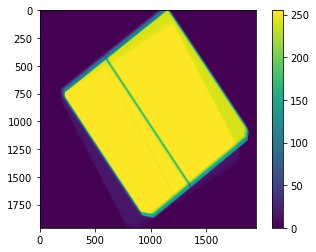

In [76]:
plt.imshow(drz['CTX'].data)
plt.colorbar()

In [98]:
lst_150 = glob.glob('F150LP/*/*flt.fits')
lst_165 = glob.glob('F165LP/*/*flt.fits')

['F150LP/57/hst_16231_57_acs_sbc_f150lp_jec457cm_flt.fits',
 'F150LP/57/hst_16231_57_acs_sbc_f150lp_jec457cl_flt.fits',
 'F150LP/57/hst_16231_57_acs_sbc_f150lp_jec457cn_flt.fits',
 'F150LP/57/hst_16231_57_acs_sbc_f150lp_jec457co_flt.fits',
 'F150LP/03/hst_16231_03_acs_sbc_f150lp_jec403ie_flt.fits',
 'F150LP/03/hst_16231_03_acs_sbc_f150lp_jec403id_flt.fits',
 'F150LP/03/hst_16231_03_acs_sbc_f150lp_jec403ib_flt.fits',
 'F150LP/03/hst_16231_03_acs_sbc_f150lp_jec403ic_flt.fits',
 'F150LP/04/hst_16231_04_acs_sbc_f150lp_jec404gw_flt.fits',
 'F150LP/04/hst_16231_04_acs_sbc_f150lp_jec404gv_flt.fits',
 'F150LP/04/hst_16231_04_acs_sbc_f150lp_jec404gy_flt.fits',
 'F150LP/04/hst_16231_04_acs_sbc_f150lp_jec404gx_flt.fits',
 'F150LP/56/hst_16231_56_acs_sbc_f150lp_jec456xp_flt.fits',
 'F150LP/56/hst_16231_56_acs_sbc_f150lp_jec456xn_flt.fits',
 'F150LP/56/hst_16231_56_acs_sbc_f150lp_jec456xo_flt.fits',
 'F150LP/56/hst_16231_56_acs_sbc_f150lp_jec456xm_flt.fits',
 'F150LP/10/hst_16231_10_acs_sbc_f150lp_